# INFO-F-422 Statistical foundations of machine learning. Kaggle project report. Aldar Saranov.

# Abstract
The following project was implemented in order to implement an apartment price prediction for the Kaggle competition. It was divided in several project parts - feature selection, model selection, model combination, model evaluation. The report will describe the implementation and description of each of these steps and analyze project details.

# Introduction
The project was implemented in R language (version 3.3.4). This report contains the main snippets of the project. The rest can be found at the [GitHub repository][1]. As a feature selection information gain filtering was used. As model selection cross-validation was applied. And finally models are combined by means of weighted average over the described models. In addition to these strategies we apply factored feature reassignment and conduct some analyzis concerning the impact of the configuration hyperparameters at the model estimate. The results have been computed and uploaded with total score 0.14474 on the test set and 0.1533264 on the train set. The submission can be found at Kaggle by nickname "INFOF422_Saranov" or "Aldar Saranov" at the leaderboard.

[1]: https://github.com/ElderMayday/kaggle

# Feature selection
**Information gain criteria**

Many features (attributes) are supposed to contribute the prediction value and still some of them should be considered inconsistent or inefficient. In order to select the desired features one can apply either **filter methods** (i.e. regarding the features independently) or **wrapper methods** (i.e. regarding subsets of feature). Still for the sake of simplicity we use filter methods. As a grade of feature "usefullness" we use information grade measure (IG). This measure is based on the notion of entropy. Entropy itself characterizes the grade of system's disorder.

$$H = - \sum_{i=1}^{n} p_i log_b (p_i), \textit{where } p_i \textit{ - probability of i-th outcome}$$

IG while performing a transition from state 1 to state 2 is as follows.

$$IG(1\rightarrow2) = H(1) - H(2)$$

After computing this value for every feature separatedly we can order the features and slice the most important ones.
**Warning!** To run the code one must download the whole repository with data files and correct the folder paths by setwd(), plus install the used libraries for the jupyter.

The following code performs the feature selection procedure. It uses FSelector package which allows to compute IG vector for each of the features.

In [1]:
library(FSelector)   #load the feature-selection library

setwd('D:/kaggle')  #TO-MODIFY sets the defaul folder depending on the directory path!!!

#takes dataframe and shows the features with satisfactory information gain
feature_selector <- function(data)
{
  #calculate the information gain of each feature
  features <- information.gain(SalePrice~., data)
  
  #result dataframe
  result = data.frame()
  
  row_names = row.names(features)
  
  #select every feature with IF higher than 0.1
  for (i in 1:nrow(features))
  {
    if (features[i, 1] > 0.1)
    {
      result <- rbind(result, data.frame("feature_name"= row_names[i], "feature_gain" = features[i, 1]))
    }
  }
  
  #order the features
  result = result[rev(order(result$feature_gain)),]

  #print the selected features
  print(result)
  
  return(result)
}

#load the train data
train = read.csv("./train.csv", header = TRUE)

#do feature selection
features = feature_selector(train)

Warning message:
"package 'FSelector' was built under R version 3.3.3"

   feature_name feature_gain
6   OverallQual    0.4922011
5  Neighborhood    0.4569727
22    GrLivArea    0.3825791
31   GarageCars    0.3281534
32   GarageArea    0.3210374
7     YearBuilt    0.2922323
15     BsmtQual    0.2870105
13    ExterQual    0.2837421
24  KitchenQual    0.2770460
18  TotalBsmtSF    0.2765359
29  GarageYrBlt    0.2569508
1    MSSubClass    0.2566161
30 GarageFinish    0.2501103
20    X1stFlrSF    0.2394652
23     FullBath    0.2339366
28   GarageType    0.2144176
8  YearRemodAdd    0.2112479
27  FireplaceQu    0.1963499
14   Foundation    0.1933651
25 TotRmsAbvGrd    0.1731205
21    X2ndFlrSF    0.1728490
3   LotFrontage    0.1547592
26   Fireplaces    0.1531060
16 BsmtFinType1    0.1519456
4       LotArea    0.1443197
33  OpenPorchSF    0.1438957
9   Exterior1st    0.1430904
10  Exterior2nd    0.1408458
19    HeatingQC    0.1329305
17   BsmtFinSF1    0.1155452
2      MSZoning    0.1111115
12   MasVnrArea    0.1031449
11   MasVnrType    0.1027884


As a result we have a table of the features ordered by IG importance that have IG higher than 0.1 and therefore passed the feature selection process. The rest features are ignored since they are considered to cause randomness in the regression problem solving.

**Adapting input data**

In order to improve prediction based on factor features we can reassign the factor features (such as "FireplaceQu") to scalar integer values where higher values correspond to generally higher prices and the lower ones to the lower prices. Unlike the initial values these scalar values will more correlate to the sale price and hence reduce the variance of the prediction. To achieve that we use agregating over the train set by the corresponding factor features. The following snippet represents factored feature aggregation.

The factor reassignment was applied for the following features: *MSZoning, Neighborhood, Exterior1st, Exterior2nd, MasVnrType, ExterQual, Foundation, BsmtQual, BsmtFinType1, HeatingQC, KitchenQual, FireplaceQu, GarageType, GarageFinish*.

In addition to adapt the input data, one must replace NA values to some specific value (0 value was used) since some predictors demand all the attributes to be real scalar values. This was applied for the following features: *LotFrontage, MasVnrType, MasVnrArea, BsmtQual, BsmtFinType1, FireplaceQu, GarageType, GarageYrBlt, GarageFinish*.

In [6]:
train = read.csv("./train.csv", header = TRUE)

group = aggregate(train[,c('SalePrice')], list(train[,'Neighborhood']), mean)  #group feature values by average price
group = group[order(group$x),]

print(group)

   Group.1         x
11 MeadowV  98576.47
10  IDOTRR 100123.78
3   BrDale 104493.75
4  BrkSide 124834.05
8  Edwards 128219.70
18 OldTown 128225.30
19  Sawyer 136793.14
2  Blueste 137500.00
23   SWISU 142591.36
15 NPkVill 142694.44
13   NAmes 145847.08
12 Mitchel 156270.12
20 SawyerW 186555.80
17  NWAmes 189050.07
9  Gilbert 192854.51
1  Blmngtn 194870.88
6  CollgCr 197965.77
7  Crawfor 210624.73
5  ClearCr 212565.43
21 Somerst 225379.84
25 Veenker 238772.73
24  Timber 242247.45
22 StoneBr 310499.00
16 NridgHt 316270.62
14 NoRidge 335295.32


The table above represents the 'Neighborhood' feature reassignment. 'MeadowV' thus is substituted to 1 and 'NoRidge' to 25. By applying similar aggregation to every factored feature, afterwards we substitute every of these factors to its ordered number which thus will correlate and contribute the price prediction. 

# Model Selection
With each another run the result may differ a little bit since the cross-validation procedure contains a randomizing step. Lets consider following problem notation:

$$D=((x_1,y_1), (x_2,y_2), ... , (x_n,y_n)) \textit{ - the train set to be taught.}$$

To estimate the model precision we permutate the observations in random mannet and split them into m folds k observations each.

$$F_1 = ((x_{1,1}, y_{1,1}),...,(x_{1,k}, y_{1,k})), ..., F_m = ((x_{m,1}, y_{m,1}),...,(x_{m,k}, y_{m,k}))$$

Then for iterations i from 1 to m we apply a training-evaluating step.

$$F_i \textit{ - current test set, } F_i^t = \bigcup \limits_{\forall j \neq i} {F_j} \textit{ - current train set.}$$

$$\textit{Let } E_i \textit{ be the estimate of i-th iteration}$$

The total estimate can be assessed as the mean of these estimates:

$$E = \frac {1} {m} \sum \limits_{i=1}^{m} {E_i} $$

As an estimate we picked rooted MSE of logarithmic values since it is the one which is used in Kaggle system.

**Implementation**
The cross-validation procedure was done manually without applying any side libraries. It includes split-folds function which permutates the data set and packs it into several folds which have size difference equal to one at most. In model-selection procedure the cross-validation is applied to every of the candidate model configurations and the model which had the best (lowest) estimate is chosen for the final usage for the test set.

The following snippet performs the model-selection for the specified three models with predefined configuration sets. The outputs are the indexes of the best configurations for each of them and logarithmic rmse for them at the train set.

In [2]:
library(lazy)
library(tree)
library(e1071)



setwd('D:/kaggle')  #TO-MODIFY sets the defaul folder depending on the directory path!!!

source("parameters.R")
source("split-folds.R")
source("feature-filter.R")
source("teach-model.R")



#teaches and evaluates an abstract model using cross-validation technique over the given [folds] with current [param] configuration
cross_validation <- function(folds, model_flag, param)
{
  mse_all = c()
  
  iteration = 1
  
  while (iteration <= length(folds))
  {
    test = folds[[iteration]]
    
    train = data.frame()
    
    fold_num = 1
    
    while (fold_num <= length(folds))
    {
      if (fold_num != iteration)
        train <- rbind(train, folds[[fold_num]])
      
      fold_num = fold_num + 1
    }
    
    model = teach_model(train, model_flag, param)
    
    prediction = test[,1:(ncol(test)-1)]
    predicted = predict(model, prediction)
    mse = mean((log2(predicted[[1]]) - log2(test[,"SalePrice"]))^2)
    mse_all = c(mse_all, mse)
    
    iteration = iteration + 1
  }
  
  return(sqrt(mse))
}



#apply model selection to [train] dataframe with [model_flag] model over [param] configuration set
select_model <- function(train, model_flag, param)
{
  folds = split_folds(train)
  
  rmse_all = c()
  
  for (i in 1:nrow(param))
  {
    #print(i)          #uncomment if you want to track selection progress
    rmse = cross_validation(folds, model_flag, param[i, ])
    rmse_all = c(rmse_all, rmse)
  }
  
  min_index = which.min(rmse_all)
  min_value = min(rmse_all)
  
  param[,'rmse'] = rmse_all
  
  return(param)
}


train_unfiltered = read.csv("./train.csv", header = TRUE)
train = feature_filter(train_unfiltered)
train = reassign_factors(train, train)
train = replace_na(train)

parameters_tree = get_parameters_tree()
result_tree = select_model(train, 1, parameters_tree)
print('tree_index = ')
print(which.min(result_tree[,'rmse']))
print('tree_rmse = ')
print(min(result_tree[,'rmse']))

parameters_lazy = get_parameters_lazy()
result_lazy = select_model(train, 2, parameters_lazy)
print('lazy_index = ')
print(which.min(result_lazy[,'rmse']))
print('lazy_rmse = ')
print(min(result_lazy[,'rmse']))

parameters_svm = get_parameters_svm()
result_svm = select_model(train, 3, parameters_svm)
print('svm_index = ')
print(which.min(result_svm[,'rmse']))
print('svm_rmse = ')
print(min(result_svm[,'rmse']))

Warning message:
"package 'tree' was built under R version 3.3.3"Warning message:
"package 'e1071' was built under R version 3.3.3"

[1] "tree_index = "
[1] 433
[1] "tree_rmse = "
[1] 0.6139877
[1] "lazy_index = "
[1] 21
[1] "lazy_rmse = "
[1] 1.184594
[1] "svm_index = "
[1] 97
[1] "svm_rmse = "
[1] 1.056393


**Model configuration analyzis**
We create predefined sets of models configurations for each of the models that are ranged within subjectively reasonable intervals. The configuration set will consist of the cartesian product of the specified values for each of the hyperparameters.

Later on we analyze the parameter impact on the prediction to justify the choice. Although as we mentioned we simply choose the configurations with minimal estimate, for sake of analytical conclusions concerning the hyperparameters one can analyze the impact of each of the hyperparameters on the prediction independently. After performing cross-validation we aggregate 

**a) Regression Trees**

Classification and regression trees (CART) were introduced hereby as one of the models. It is based on recursive split of the input space into two subspaces by some input condition. The split is done in such way that it allows to differentiate the data observations as precise as possible at the current step. After a binary split the tree builder repeats the process for the two subspaces until no more useful splits can be made or some additional terminate criterea is met.

In our case for the 'tree' package the effective hyperparameters are:

*mincut* - the minimum number of observations to include in either child node.

*minsize* - the smallest allowed node size.

*mindev* - the within-node deviance must be at least this times that of the root node for the
node to be split.

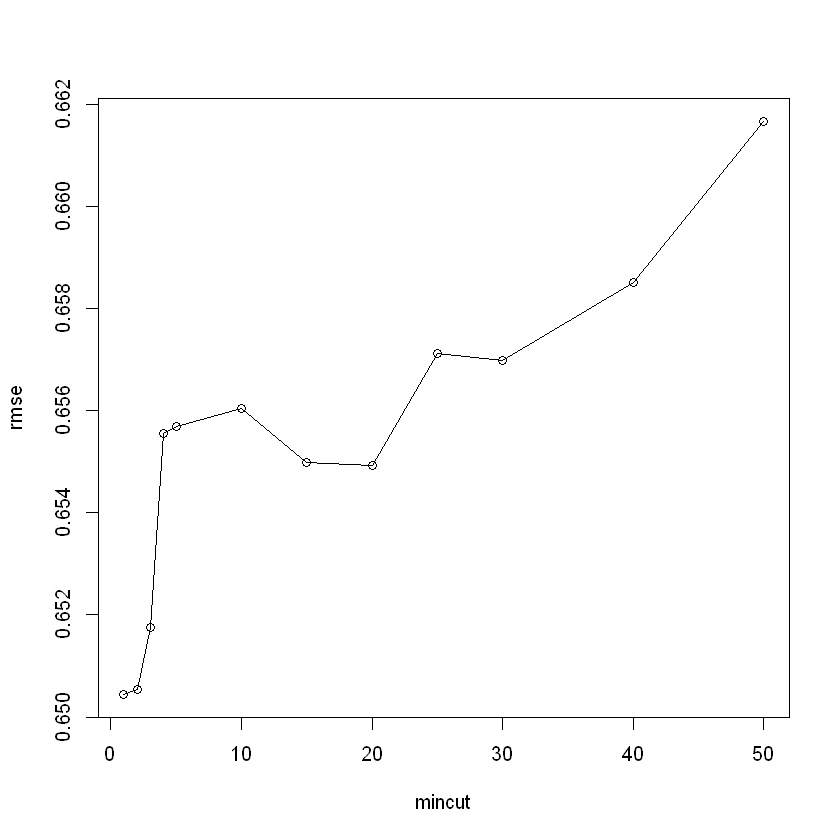

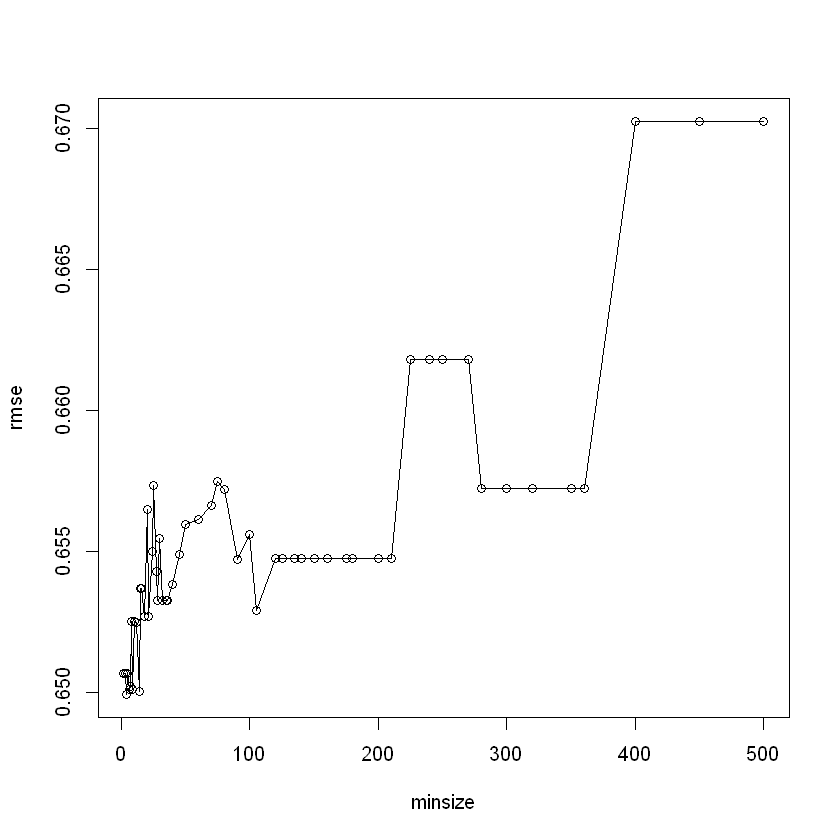

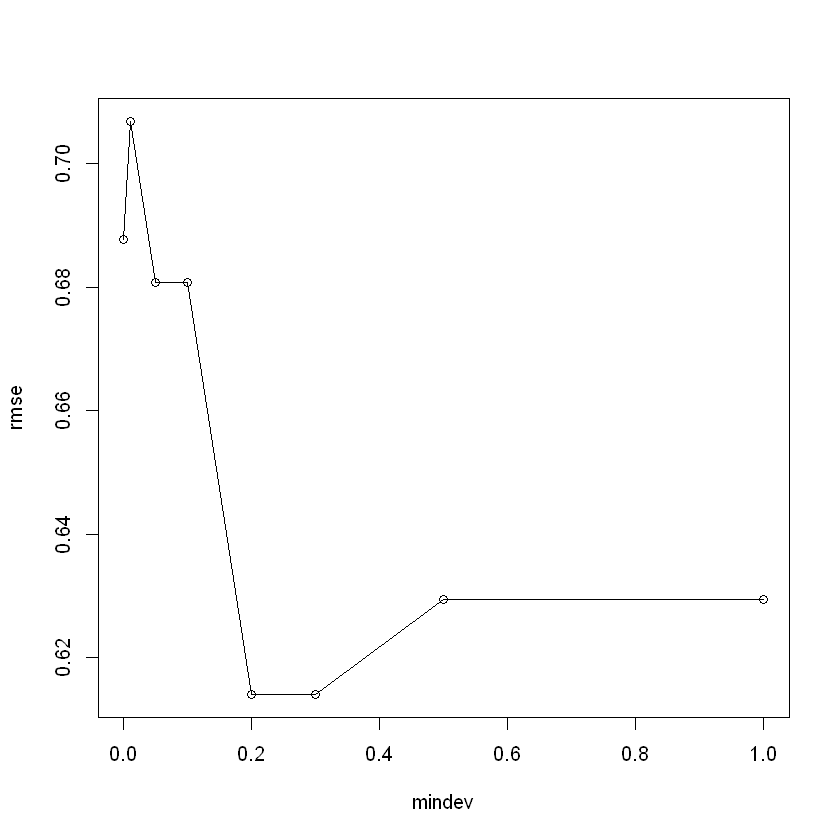

In [8]:
group = aggregate(result_tree[,c('rmse')], list(result_tree$mincut), mean)  # 10
plot(group[,1],group[,2], xlab="mincut", ylab="rmse")
lines(group[,1],group[,2])

group = aggregate(result_tree[,c('rmse')], list(result_tree$minsize), mean)  # 10
plot(group[,1],group[,2], xlab="minsize", ylab="rmse")
lines(group[,1],group[,2])

group = aggregate(result_tree[,c('rmse')], list(result_tree$mindev), mean)  # 10
plot(group[,1],group[,2], xlab="mindev", ylab="rmse")
lines(group[,1],group[,2])

**b) Lazy Estimate**

*cmbPar* - parameter controlling the local combination of models.

*lambda* - initialization of the diagonal elements of the local variance/covariance matrix
for Ridge Regression.

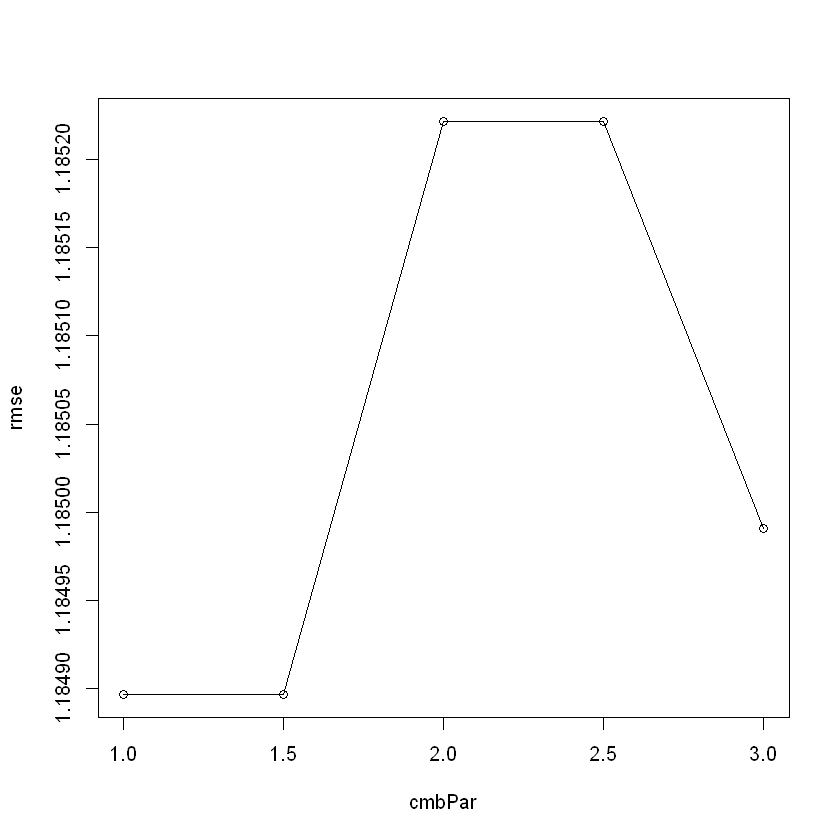

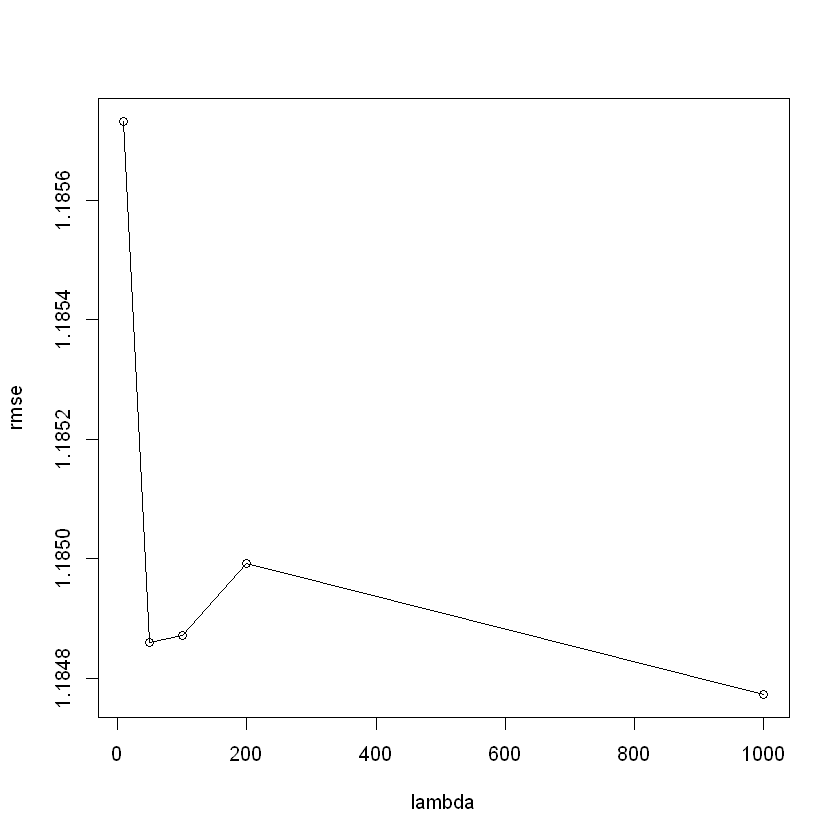

In [10]:
group = aggregate(result_lazy[,c('rmse')], list(result_lazy$cmbPar), mean)  #3
plot(group[,1],group[,2], xlab="cmbPar", ylab="rmse")
lines(group[,1],group[,2])

group = aggregate(result_lazy[,c('rmse')], list(result_lazy$lambda), mean)  #200
plot(group[,1],group[,2], xlab="lambda", ylab="rmse")
lines(group[,1],group[,2])

**c) Support Vector Machine**

*degree* - parameter needed for kernel of type polynomial.

*nu* - parameter needed for nu-classification, nu-regression, and one-classification.

*tolerance* - tolerance of termination criterion.

*epsilon* - epsilon in the insensitive-loss function.

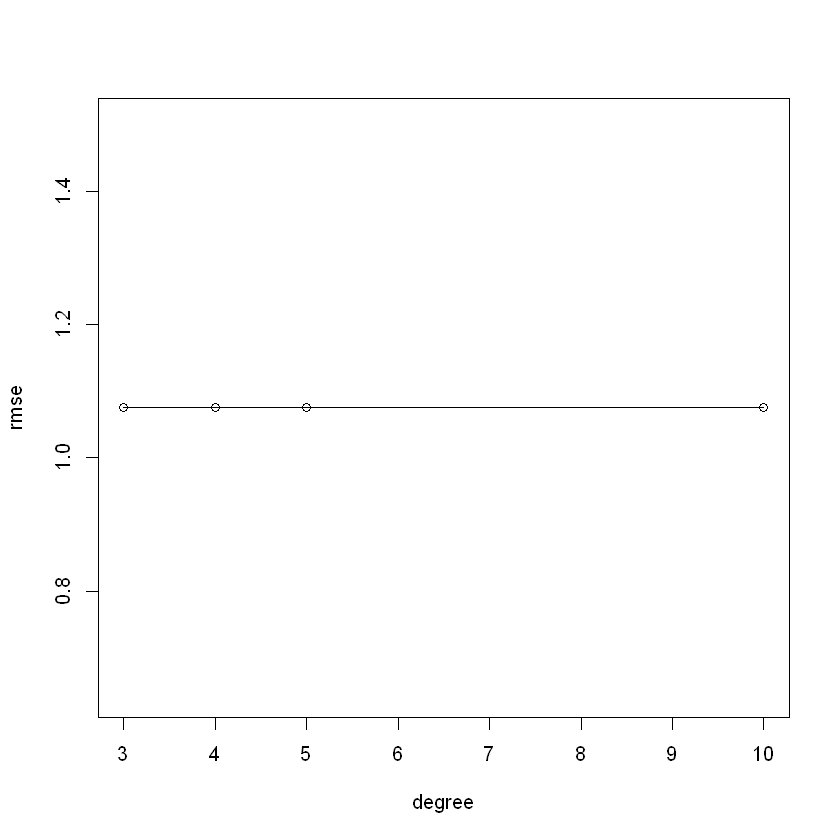

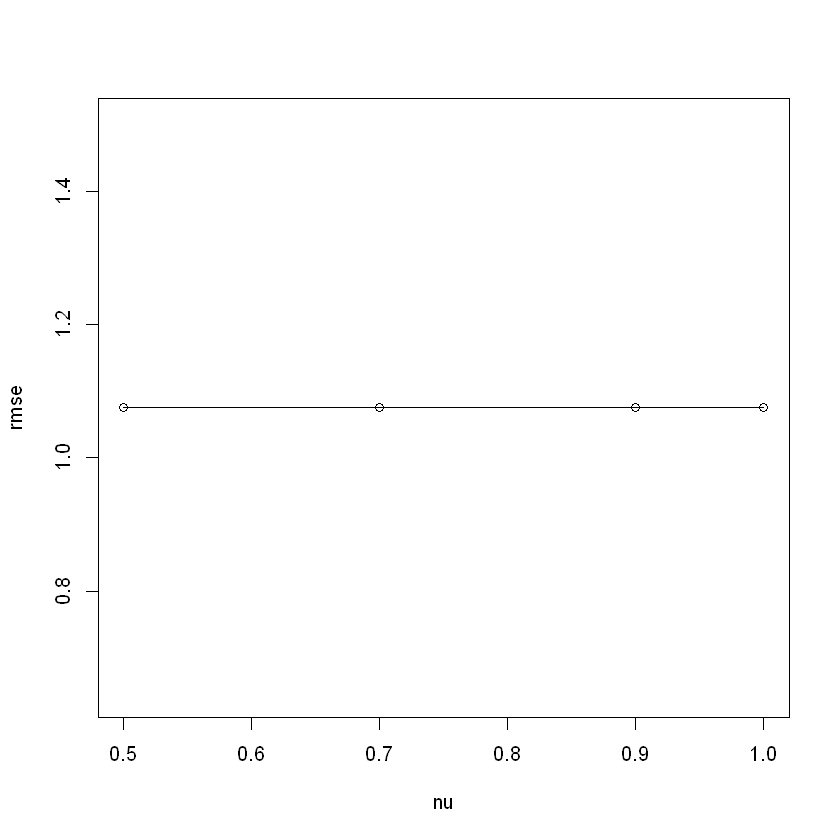

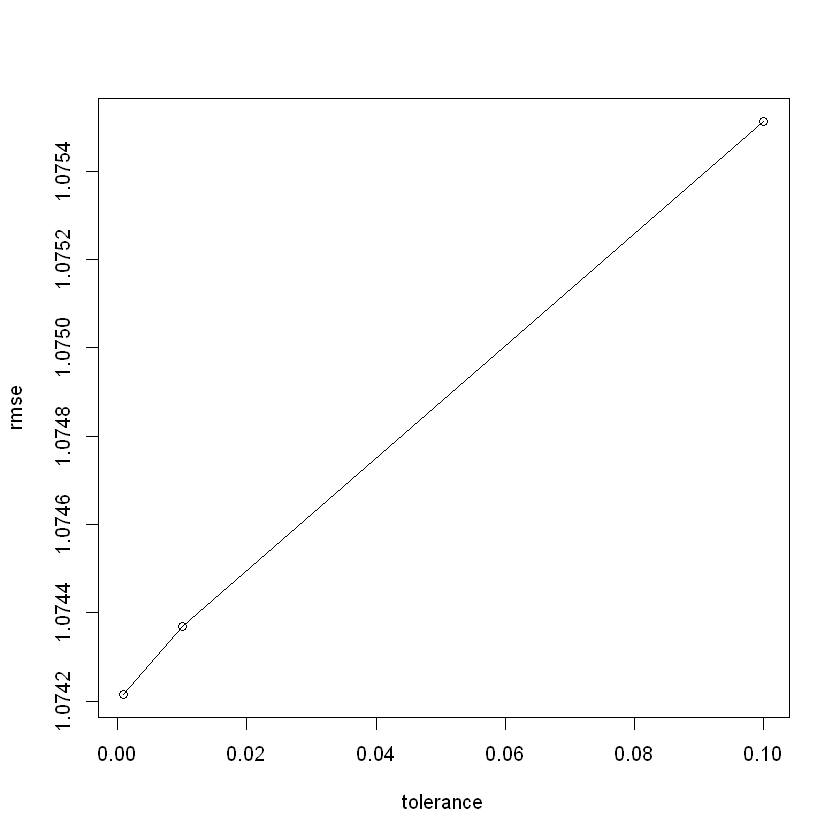

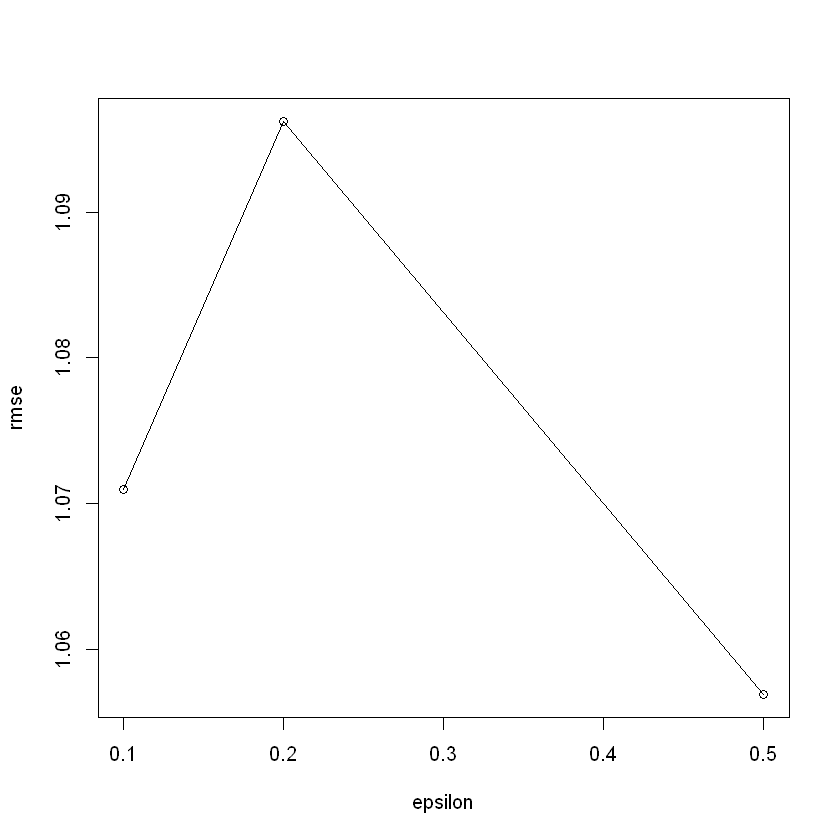

In [12]:
group = aggregate(result_svm[,c('rmse')], list(result_svm$degree), mean)  #no impact
plot(group[,1],group[,2], xlab="degree", ylab="rmse")
lines(group[,1],group[,2])

group = aggregate(result_svm[,c('rmse')], list(result_svm$nu), mean)  #no impact
plot(group[,1],group[,2], xlab="nu", ylab="rmse")
lines(group[,1],group[,2])

group = aggregate(result_svm[,c('rmse')], list(result_svm$tolerance), mean)   #0.001
plot(group[,1],group[,2], xlab="tolerance", ylab="rmse")
lines(group[,1],group[,2])

group = aggregate(result_svm[,c('rmse')], list(result_svm$epsilon), mean)  #0.1
plot(group[,1],group[,2], xlab="epsilon", ylab="rmse")
lines(group[,1],group[,2])

# Model combination
We can use the implemented models all together (i.e. in an ensemble) in order to increase their performance.

There are two known model combination facts:
1) Error mean cannot be reduced without increase of error variance.
2) Error variance can be reduced by model combination without increase of mean error.

We use weighted average over the predictions as their combination. Suppose:

$$y_{i,j} \textit{ - prediction of the i-th observation by the j-th predictor}$$

Then:

$$ y_{i} = \sum \limits_{\forall{j}} {w_j \times y_{i,j}} \textit{, where } w_j \textit{ is the weight of the j-th predictor} $$

The sum of the weights **w** should be equal to one since any other distribution will cause mean shift. The weights should be computed in such manner that the final result will more bias towards to the generally better models and less bias to the generally worse models.

In [3]:
#performs model combination, outputs the result on test data, estimates mse on train data

library(lazy)
library(tree)
library(e1071)

setwd('D:/kaggle')  #TO-MODIFY sets the defaul folder depending on the directory path!!!

source("parameters.R")
source("feature-filter.R")
source("teach-model.R")

combine <- function(data, model_tree, model_lazy, model_svm, rmse_tree, rmse_lazy, rmse_svm)
{
  p1 = 1 / rmse_tree
  p2 = 1/ rmse_lazy
  p3 = 1/ rmse_svm
  
  s = p1 + p2 + p3
  w1 = p1 / s
  w2 = p2 / s
  w3 = p3 / s
  
  predicted_tree = predict(model_tree, data)
  predicted_lazy = predict(model_lazy, data)[[1]]  #[[1]] since lazy package implementation returns the result as a list containing a vector as the first element
  predicted_svm = predict(model_svm, data)
  
  predicted = predicted_tree * w1 + predicted_lazy * w2 + predicted_svm * w3
  
  return(predicted)
}

train_raw = read.csv("./train.csv", header = TRUE)
train = feature_filter(train_raw)
train = reassign_factors(train, train)
train = replace_na(train)


#assign hardcoded precomputated indexes of the best model configurations
tree_conf_id = 9
lazy_conf_id = 6
svm_conf_id = 33

tree_parameters = get_parameters_tree()[tree_conf_id,]
lazy_parameters = get_parameters_lazy()[lazy_conf_id,]
svm_parameters = get_parameters_svm()[svm_conf_id,]

rmse_tree = 0.5835374
rmse_lazy = 0.2210736
rmse_svm = 0.9607639

model_tree = teach_model(train, 1, tree_parameters)
model_lazy = teach_model(train, 2, lazy_parameters)
model_svm = teach_model(train, 3, svm_parameters)

#apply to train set (to evaluate combined rmse)

data = replace_na(train)[,1:(ncol(train)-1)]   #train data without SalePrice column
predicted = combine(data, model_tree, model_lazy, model_svm, rmse_tree, rmse_lazy, rmse_svm)

mse = mean((log2(predicted) - log2(train[,'SalePrice']))^2)
rmse = sqrt(mse)

print(mse)
print(rmse)

[1] 0.023509
[1] 0.1533264
